### Загрузим датасет

In [1]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = h5py.File('/home/kmouraviev/NYU_dataset_hdf5/data.hdf5', 'r')
rgbs = dataset['data']
depths = dataset['label']

In [3]:
rgbs = np.array(rgbs)
depths = np.array(depths)

In [4]:
sample_ids = np.random.choice(np.arange(len(rgbs)), size=1000, replace=False)
rgbs_sample = rgbs[sample_ids]
depths_sample = depths[sample_ids]

In [5]:
rgbs_train = rgbs[:40000]
depths_train = depths[:40000]
rgbs_val = rgbs[40000:]
depths_val = depths[40000:]

### Получим предсказанные нейросетью глубины

In [6]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.15
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [7]:
from keras.models import load_model
model = load_model('/home/kmouraviev/FCRN_notebooks/experiment1_weights/all_layers_trained.hdf5')

In [8]:
depths_sample_predicted = model.predict(rgbs_sample)

## Bilateral Inception

Алгоритм взят из статьи https://pdfs.semanticscholar.org/727d/31a2838a67955d213bb4e1b72d19812877e7.pdf

Сначала попробуем в качестве суперпикселей использовать просто квадраты 7х7. В качестве фичей - координаты и саму глубину.

### Зададим переменные фильтра

In [9]:
feature_plh = tf.placeholder(tf.float32, shape=(None, 1024, 3))
z_plh = tf.placeholder(tf.float32, shape=(None, 1024, 1))
gt_plh = tf.placeholder(tf.float32, shape=(None, 1024, 1))

In [10]:
Lambda = tf.Variable(np.eye(3), dtype=tf.float32, trainable=True)
theta = tf.Variable([1], dtype=tf.float32, trainable=True)

In [11]:
Lf = tf.einsum('ijk,kl->ijl', feature_plh, tf.transpose(Lambda))

In [24]:
# D_ij = ||Lf_i - Lf_j||^2
lf1_tiled = tf.tile(tf.expand_dims(Lf, axis=1), [1, 1024, 1, 1])
lf2_tiled = tf.tile(tf.expand_dims(Lf, axis=2), [1, 1, 1024, 1])
D = tf.reduce_sum((lf1_tiled - lf2_tiled) ** 2, axis=-1)

In [26]:
K = tf.nn.softmax(theta * D, axis=2)

In [27]:
z_new = tf.einsum('ijk,ikl->ijl', K, z_plh)

### Зададим оптимизатор

In [28]:
loss = tf.losses.mean_squared_error(z_new, gt_plh)
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss, var_list=[Lambda, theta])

()


### Создадим обучающую выборку

In [30]:
def extract_superpixels(image):
    superpixels = []
    for i in range(0, image.shape[0], 7):
        for j in range(0, image.shape[0], 7):
            superpixels.append(image[i:i+7, j:j+7].mean())
    return np.array(superpixels)

In [31]:
def extract_features(image):
    features = []
    for i in range(0, image.shape[0], 7):
        for j in range(0, image.shape[0], 7):
            features.append([i + 4, j + 4, image[i:i+7, j:j+7].mean()])
    return np.array(features)

In [32]:
from tqdm import tqdm_notebook

In [33]:
prediction_superpixels = np.array([extract_superpixels(image) for image in tqdm_notebook(depths_sample_predicted)])
gt_superpixels = np.array([extract_superpixels(image) for image in tqdm_notebook(depths_sample)])
prediction_features = np.array([extract_features(image) for image in tqdm_notebook(depths_sample_predicted)])

In [34]:
prediction_superpixels = prediction_superpixels[:, :, np.newaxis]
gt_superpixels = gt_superpixels[:, :, np.newaxis]

In [35]:
print(prediction_superpixels.shape, gt_superpixels.shape, prediction_features.shape)

(1000, 1024, 1) (1000, 1024, 1) (1000, 1024, 3)


### Запустим обучение

In [36]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [37]:
from tqdm import tqdm

In [43]:
BATCH_SIZE = 16

In [44]:
loss_history = []
for i in tqdm(range(100)):
    ids = np.random.choice(np.arange(len(depths_sample)), size=BATCH_SIZE, replace=False)
    features = prediction_features[ids]
    gt = gt_superpixels[ids]
    prediction = prediction_superpixels[ids]
    feed_dict = {feature_plh: features,
                z_plh: prediction,
                gt_plh: gt
               }
    sess.run(train_step, feed_dict=feed_dict)
    loss_value = sess.run(loss, feed_dict=feed_dict)
    loss_history.append(loss_value)


100%|██████████| 100/100 [00:03<00:00, 27.36it/s]

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

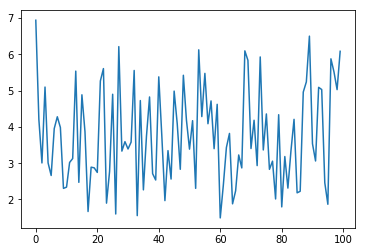

In [46]:
plt.plot(loss_history)